<a href="https://colab.research.google.com/github/mdzikrim/DeepLearning/blob/main/Attention_and_Transformer_HandsOn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Persiapan Lingkungan**

Instal dan import library yang dibutuhkan, set seed untuk reproducibility, dan cek device (CPU/GPU).

In [1]:
# ===== IMPORTS & SETUP =====
!pip install torch torchvision --quiet  # Instalasi PyTorch dan Torchvision

import torch  # Framework utama untuk deep learning
import torch.nn as nn  # Modul neural network
import torch.optim as optim  # Optimizer
import math
import random
import numpy as np

# SET SEED untuk memastikan hasil yang sama saat direstart
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Cek device: gunakan GPU jika tersedia, jika tidak, pakai CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')  # Contoh output: Device: cuda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.9 MB/s eta 0:00:00
Device: cpu


# **2. Scaled Dot‑Product Attention (Single Head)**

Implementasi inti attention: menghitung skor, normalisasi softmax, dan weighted sum.

In [2]:
# ===== SCALED DOT‑PRODUCT ATTENTION =====
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    q, k, v: Tensor shape (..., seq_len, d_k)
    mask: Tensor optional untuk masking (padding atau subsequent)
    Langkah:
    1. Hitung skor: scores = Q · K^T / sqrt(d_k)
    2. Terapkan mask (jika ada)
    3. Softmax untuk mendapat attention weights
    4. Weighted sum: output = weights · V
    """
    d_k = q.size(-1)  # Dimensi key/query
    # Matmul Q dan K^T, lalu skala
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        # Mask value yang dipad menjadi -inf agar softmax memberikan 0
        scores = scores.masked_fill(mask == 0, float('-inf'))
    # Softmax pada dimensi k
    weights = torch.softmax(scores, dim=-1)  # Bentuk: (..., seq_len_q, seq_len_k)
    # Weighted sum pada V
    output = torch.matmul(weights, v)  # Bentuk: (..., seq_len_q, d_k)
    return output, weights  # Kembalikan output dan attention weights

# **3. Multi‑Head Attention**

Gabungkan beberapa attention head agar model dapat fokus ke berbagai sub-ruang informasi.

In [3]:
# ===== MULTI‑HEAD ATTENTION =====
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, 'd_model harus kelipatan dari num_heads'
        self.d_k = d_model // num_heads  # Dimensi per head
        self.num_heads = num_heads
        # Linear layers untuk Q, K, V
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        # Output projection
        self.fc = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)  # Bentuk q: (batch_size, seq_len, d_model)
        # Proyeksi dan reshape untuk multi-head: (batch, seq_len, d_model) -> (batch, num_heads, seq_len, d_k)
        Q = self.w_q(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        # Hitung self-attention untuk setiap head
        out, attn = scaled_dot_product_attention(Q, K, V, mask)
        # Gabungkan kembali heads: (batch, num_heads, seq_len, d_k) -> (batch, seq_len, d_model)
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        # Proyeksi akhir
        out = self.fc(out)
        return out, attn  # out: (batch, seq_len, d_model), attn: (batch, num_heads, seq_len, seq_len)

# **4. Positional Encoding**

Menambahkan informasi posisi ke embedding input agar model tahu urutan token.

In [4]:
# ===== POSITIONAL ENCODING =====
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # Buat tensor position encoding (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        positions = torch.arange(0, max_len).unsqueeze(1).float()  # Bentuk: (max_len, 1)
        # Hitung faktor pembagi untuk dimensi sin/cos
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        # Isi nilai sin pada dimensi genap
        pe[:, 0::2] = torch.sin(positions * div_term)
        # Isi nilai cos pada dimensi ganjil
        pe[:, 1::2] = torch.cos(positions * div_term)
        pe = pe.unsqueeze(0)  # Tambah batch dimensi -> (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]  # Tambahkan positional encoding
        return x

# **5. Feed‑Forward & Layer Normalization**

MLP per posisi dan layer normalization dengan residual connection.

In [5]:
# ===== POSITION‑WISE FEED‑FORWARD =====
class PositionwiseFFN(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        # Dua lapis linear dengan aktivasi ReLU di tengah
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),  # Ubah ke dimensi d_ff
            nn.ReLU(),                  # Non-linearitas
            nn.Linear(d_ff, d_model),   # Kembali ke dimensi d_model
            nn.Dropout(dropout)         # Dropout untuk regularisasi
        )
        self.norm = nn.LayerNorm(d_model)  # Layer normalization setelah residual

    def forward(self, x):
        out = self.ffn(x)  # Hasil MLP (batch, seq_len, d_model)
        return self.norm(x + out)  # Residual + Norm

# **6. Transformer Encoder Layer**

Kombinasikan multi‑head attention, residual, layer norm, dan feed‑forward.

In [6]:
# ===== ENCODER LAYER =====
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # Multi-head attention
        self.norm1 = nn.LayerNorm(d_model)                # Norm setelah residual attention
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout) # Feed-forward

    def forward(self, x, mask=None):
        # Self-attention
        attn_out, _ = self.mha(x, x, x, mask)  # x sebagai Q,K,V (encoder)
        # Residual + layer norm
        x = self.norm1(x + attn_out)
        # Positional feed-forward + residual + norm
        x = self.ffn(x)
        return x

# **7. Membangun Model Transformer Sederhana**

Gabungkan embedding, positional encoding, dan beberapa encoder layer untuk membentuk encoder-only Transformer.

In [7]:
# ===== TRANSFORMER ENCODER & LAYER WITH ATTENTION RETURN =====
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout)

    def forward(self, x, mask=None, return_attn=False):
        # Self-attention
        attn_out, attn_weights = self.mha(x, x, x, mask)
        x = self.norm1(x + attn_out)
        x = self.ffn(x)
        if return_attn:
            return x, attn_weights
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, num_heads, d_ff, max_len):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        # Simpan num_heads untuk return_attn
        self.num_heads = num_heads
        # Buat N encoder layers
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff) for _ in range(N)
        ])
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, src, return_attn=False):
        # src: (bsz, seq_len)
        x = self.embed(src) * math.sqrt(self.embed.embedding_dim)
        x = self.pos_enc(x)
        attn_list = []
        for layer in self.layers:
            if return_attn:
                x, attn = layer(x, return_attn=True)
                attn_list.append(attn)
            else:
                x = layer(x)
        logits = self.fc(x)  # (bsz, seq_len, vocab_size)
        if return_attn:
            # Stack menjadi tensor shape (num_layers, bsz, num_heads, seq_len, seq_len)
            attn_stack = torch.stack(attn_list, dim=0)
            return logits, attn_stack
        return logits

# Hyperparameters contoh dan instansiasi model
VOCAB_SIZE = 100
D_MODEL = 64
N_LAYERS = 2
NUM_HEADS = 4
D_FF = 256
MAX_LEN = 50

model = TransformerEncoder(VOCAB_SIZE, D_MODEL, N_LAYERS, NUM_HEADS, D_FF, MAX_LEN).to(device)
print(model)

TransformerEncoder(
  (embed): Embedding(100, 64)
  (pos_enc): PositionalEncoding()
  (layers): ModuleList(
    (0-1): 2 x EncoderLayer(
      (mha): MultiHeadAttention(
        (w_q): Linear(in_features=64, out_features=64, bias=True)
        (w_k): Linear(in_features=64, out_features=64, bias=True)
        (w_v): Linear(in_features=64, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ffn): PositionwiseFFN(
        (ffn): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=100, bias=True)
)


# **8. Contoh Dataset Main‑Main (Toy Task)**

Buat toy dataset copy task—model belajar menyalin input ke output.

In [8]:
# ===== DATASET TOY COPY =====
from torch.utils.data import Dataset, DataLoader

class CopyDataset(Dataset):
    def __init__(self, seq_len, vocab_size, size):
        self.data = [torch.randint(1, vocab_size, (seq_len,)) for _ in range(size)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]          # Input: sequence random
        y = x.clone()               # Target: sama persis dengan input
        return x, y

# Konfigurasi dataset dan loader
SEQ_LEN = 20
TRAIN_SIZE = 1000
BATCH_SIZE = 32

dataset = CopyDataset(SEQ_LEN, VOCAB_SIZE, TRAIN_SIZE)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# **9. Training Loop**

 Standard PyTorch training dengan CrossEntropyLoss, view ulang tensor, dan optim.Adam.

In [14]:
# ===== TRAINING =====
criterion = nn.CrossEntropyLoss()  # Loss untuk multi-class classification
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Optimizer Adam

epochs = 5
loss_history = [] # Initialize an empty list to store loss values

for ep in range(epochs):
    model.train()
    total_loss = 0
    for src, tgt in loader:
        src, tgt = src.to(device), tgt.to(device)  # Pindahkan ke device
        optimizer.zero_grad()  # Reset grad
        logits = model(src)  # (batch, seq_len, vocab_size)
        # View ulang logits dan target untuk CrossEntropy
        loss = criterion(logits.view(-1, VOCAB_SIZE), tgt.view(-1))
        loss.backward()  # Backprop
        optimizer.step()  # Update parameter
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    loss_history.append(avg_loss) # Append the average loss for the epoch
    print(f'Epoch {ep+1}, Loss: {avg_loss:.4f}')  # Tampilkan loss rata-rata

Epoch 1, Loss: 0.0233
Epoch 2, Loss: 0.0061
Epoch 3, Loss: 0.0031
Epoch 4, Loss: 0.0020
Epoch 5, Loss: 0.0014


# **10. Inferensi & Demo**

Jalankan model dalam mode eval, generate prediksi, dan bandingkan dengan input.

In [15]:
# ===== INFERENSI =====
model.eval()  # Matikan dropout, dsb.
with torch.no_grad():
    sample = torch.randint(1, VOCAB_SIZE, (1, SEQ_LEN)).to(device)  # Contoh input
    logits = model(sample)  # (1, seq_len, vocab_size)
    pred = logits.argmax(dim=-1)  # Pilih token dengan skor tertinggi
    print('Input :', sample.cpu().numpy())  # Tampilkan input asli
    print('Predicted output:', pred.cpu().numpy())  # Tampilkan hasil prediksi

Input : [[47 57 14  1 47  9 89 80 41 98 21 75  5 63 16 31 57 25 10 47]]
Predicted output: [[47 57 14  1 47  9 89 80 41 98 21 75  5 63 16 31 57 25 10 47]]


# **11. Visualisasi Attention Heatmap**

Tampilkan heatmap attention untuk satu head untuk pahami pola perhatian.

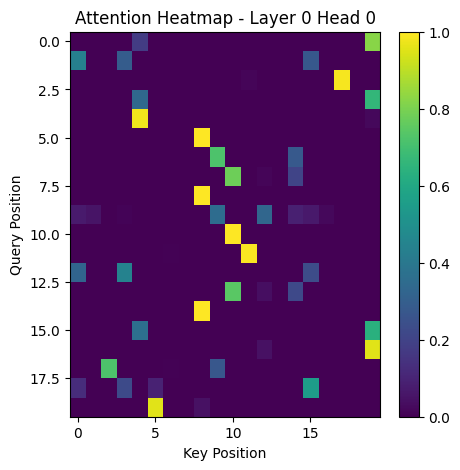

In [16]:
# ===== Attention Heatmap =====
model.eval()
with torch.no_grad():
    # Ambil satu sampel input acak
    sample = torch.randint(1, 100, (1,20)).to(device)
    # Forward pass untuk mendapatkan attention weights
    _, attn = model(sample, return_attn=True)

# attn shape: (num_layers, batch, num_heads, seq_len, seq_len)
# Pilih layer pertama (0), batch pertama (0), dan head pertama (0)
head0 = attn[0, 0, 0].cpu().numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.imshow(head0, aspect='auto')
plt.colorbar()
plt.title('Attention Heatmap - Layer 0 Head 0')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.show()

# **12. Plot Training Loss**

Melihat Gambar tren loss untuk pantau konvergensi.

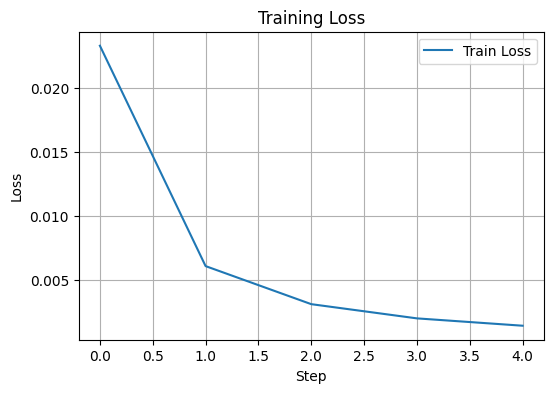

In [17]:
def plot_training_loss():
    import matplotlib.pyplot as plt
    try:
        # Pastikan loss_history sudah berjalan dan berisi data
        plt.figure(figsize=(6,4))
        plt.plot(loss_history, label='Train Loss')
        plt.title('Training Loss')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.grid()
        plt.legend()
        plt.show()
    except NameError:
        print('Variabel loss_history tidak ditemukan. Pastikan kamu sudah menjalankan Training Loop (Section 9).')

# Panggil fungsi untuk menampilkan plot
plot_training_loss()

# **13. Combined Visualization (Attention & Loss). Combined Visualization (Attention & Loss)**

Satu tampilan berisi heatmap attention & grafik loss.

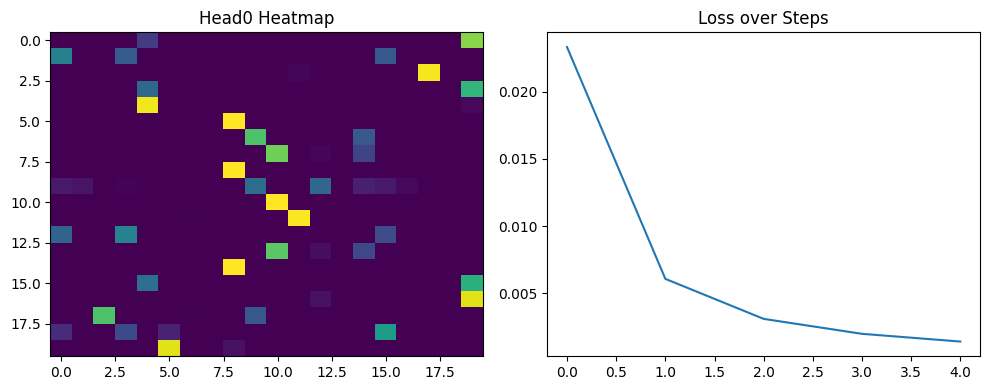

In [18]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(head0, aspect='auto'); ax[0].set_title('Head0 Heatmap')
ax[1].plot(loss_history); ax[1].set_title('Loss over Steps')
plt.tight_layout(); plt.show()

# **14. Masking Mechanisms**

Padding mask mencegah attention pada token <pad>, sedangkan look‑ahead mask (subsequent mask) mencegah decoder melihat token di posisi masa depan.

In [19]:
# ===== MASKING UTILITIES =====

def create_padding_mask(seq, pad_token=0):
    """Return mask shape (batch, 1, 1, seq_len) with 0 for pad positions."""
    mask = (seq == pad_token).unsqueeze(1).unsqueeze(2)  # (batch,1,1,seq)
    return mask  # Bool tensor

def create_look_ahead_mask(size):
    """Upper‑triangular mask untuk melarang melihat ke depan."""
    mask = torch.triu(torch.ones((size, size), device=seq.device), diagonal=1).bool()
    return mask  # (seq, seq)

# **15. Learning Rate Scheduler**

Gunakan warm‑up di awal training lalu linear decay—praktik umum di Transformer.

In [20]:
from torch.optim.lr_scheduler import LambdaLR

# Warm‑up + linear decay scheduler
warmup_steps = 400
scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda step: min((step+1)/warmup_steps, 1.0)  # Naik linier sampai warmup
)

# Tambahkan scheduler.step() di akhir setiap batch atau epoch

# **16. Save & Load Model**

Simpan parameter model setelah training dan muat kembali untuk inferensi.

In [21]:
# ===== SAVE MODEL =====
SAVE_PATH = 'transformer_copytask.pth'
torch.save(model.state_dict(), SAVE_PATH)
print('Model saved to', SAVE_PATH)

# ===== LOAD MODEL =====
loaded_model = TransformerEncoder(VOCAB_SIZE, D_MODEL, N_LAYERS, NUM_HEADS, D_FF, MAX_LEN).to(device)
loaded_model.load_state_dict(torch.load(SAVE_PATH))
loaded_model.eval()
print('Model loaded and ready for inference')

Model saved to transformer_copytask.pth
Model loaded and ready for inference


# **17. Evaluation Metric: Token‑Level Accuracy**

Hitung proporsi token yang disalin dengan benar (akurasi) pada dataset validasi.

In [22]:
# ===== EVALUATION =====
correct = total_tokens = 0
loaded_model.eval()
with torch.no_grad():
    for src, tgt in loader:  # Pakai loader yang sama sebagai demo
        src, tgt = src.to(device), tgt.to(device)
        logits = loaded_model(src)
        pred = logits.argmax(dim=-1)
        correct += (pred == tgt).sum().item()
        total_tokens += tgt.numel()
accuracy = correct / total_tokens * 100
print(f'Token‑level accuracy: {accuracy:.2f}%')

Token‑level accuracy: 100.00%
